In [41]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from keras import regularizers
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
modeldir = "/content/drive/MyDrive/palau_merged.csv"

In [4]:
palau = pd.read_csv(modeldir).drop("Unnamed: 0", axis=1)
palau.columns = [col.replace(" ", "_").lower() for col in palau.columns]
palau.head(5)

,year,month,seats_arrivals_intl,seats_arrivals_total,number_of_flights_intl,number_of_flights_total,date,japan,south_korea,taiwan,china,usa/canada,europe,others,total
0,2019,1,13048.0,13048.0,75.0,75.0,2019-01-01,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0
1,2019,2,13281.0,13281.0,74.0,74.0,2019-02-01,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0
2,2019,3,12870.0,12870.0,73.0,73.0,2019-03-01,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0
3,2019,4,10806.0,10806.0,64.0,64.0,2019-04-01,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0
4,2019,5,11472.0,11472.0,67.0,67.0,2019-05-01,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0


In [5]:
data = palau.drop(["date", "year", "month"], axis=1)
data.head(5)

,seats_arrivals_intl,seats_arrivals_total,number_of_flights_intl,number_of_flights_total,japan,south_korea,taiwan,china,usa/canada,europe,others,total
0,13048.0,13048.0,75.0,75.0,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0
1,13281.0,13281.0,74.0,74.0,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0
2,12870.0,12870.0,73.0,73.0,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0
3,10806.0,10806.0,64.0,64.0,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0
4,11472.0,11472.0,67.0,67.0,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0


In [19]:
def lstm_tune(X, y, neurons, recurrent_dropout, n_steps, dropout=0.2, nb_epoch=100):
    loss_df = pd.DataFrame()
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons,
                   dropout=dropout,
                   recurrent_dropout=recurrent_dropout,
                   kernel_regularizer=regularizers.l2(0.001),
                   return_sequences=False,
                   input_shape=(n_steps, X.shape[-1])))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(n_features))
    model.compile(loss='mse', optimizer='RMSprop')
    # fit model
    train_mse, val_mse = list(), list()
    for i in range(nb_epoch):
        print("Epoch " + str(i+1) + " out of " + str(nb_epoch))
        lstm_model = model.fit(
            X, y, epochs=1, shuffle=True, validation_data=(X_test, y_test))
        train_mse.append(float(lstm_model.history["loss"][0]))
        val_mse.append(float(lstm_model.history["val_loss"][0]))
        model.reset_states()
    loss_df['train'], loss_df['validation'] = train_mse, val_mse
    return loss_df

In [20]:
# Specify the number of time steps and features
n_steps = 12
n_features = data.shape[1]

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(0.9 * len(data))
train_data, test_data = data_scaled[:train_size,:], data_scaled[train_size-n_steps:,:]

# Define the training and testing data sets
X_train, y_train = [], []
for i in range(n_steps, len(train_data)):
    X_train.append(train_data[i-n_steps:i,:])
    y_train.append(train_data[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_steps, len(test_data)):
    X_test.append(test_data[i-n_steps:i,:])
    y_test.append(test_data[i,:])
X_test, y_test = np.array(X_test), np.array(y_test)

In [21]:
losses = pd.DataFrame()
rds = [0.2, 0.4, 0.5]
for rd in rds:
    print(f"Recurrent_Dropout = {rd}:")
    loss = lstm_tune(X_train, y_train, recurrent_dropout=rd, n_steps=n_steps, 
                     neurons=64, nb_epoch=100)
    losses = losses.append(loss)

Recurrent_Dropout = 0.2:
Epoch 1 out of 100
1/1 [==============================] - 17s 17s/step - loss: 0.0817 - val_loss: 0.0769
Epoch 2 out of 100
1/1 [==============================] - 0s 64ms/step - loss: 0.0749 - val_loss: 0.0735
Epoch 3 out of 100
1/1 [==============================] - 0s 67ms/step - loss: 0.0701 - val_loss: 0.0700
Epoch 4 out of 100
1/1 [==============================] - 0s 65ms/step - loss: 0.0686 - val_loss: 0.0680
Epoch 5 out of 100
1/1 [==============================] - 0s 86ms/step - loss: 0.0633 - val_loss: 0.0658
Epoch 6 out of 100
1/1 [==============================] - 0s 69ms/step - loss: 0.0648 - val_loss: 0.0632
Epoch 7 out of 100
1/1 [==============================] - 0s 73ms/step - loss: 0.0614 - val_loss: 0.0624
Epoch 8 out of 100
1/1 [==============================] - 0s 73ms/step - loss: 0.0600 - val_loss: 0.0589
Epoch 9 out of 100
1/1 [==============================] - 0s 76ms/step - loss: 0.0582 - val_loss: 0.0601
Epoch 10 out of 100
1/1 [=====

<ipython-input-21-3b9950551575>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  losses = losses.append(loss)


1/1 [==============================] - 2s 2s/step - loss: 0.0918 - val_loss: 0.0852
Epoch 2 out of 100
1/1 [==============================] - 0s 75ms/step - loss: 0.0809 - val_loss: 0.0837
Epoch 3 out of 100
1/1 [==============================] - 0s 65ms/step - loss: 0.0772 - val_loss: 0.0823
Epoch 4 out of 100
1/1 [==============================] - 0s 79ms/step - loss: 0.0747 - val_loss: 0.0808
Epoch 5 out of 100
1/1 [==============================] - 0s 77ms/step - loss: 0.0732 - val_loss: 0.0794
Epoch 6 out of 100
1/1 [==============================] - 0s 76ms/step - loss: 0.0719 - val_loss: 0.0780
Epoch 7 out of 100
1/1 [==============================] - 0s 61ms/step - loss: 0.0714 - val_loss: 0.0762
Epoch 8 out of 100
1/1 [==============================] - 0s 76ms/step - loss: 0.0695 - val_loss: 0.0748
Epoch 9 out of 100
1/1 [==============================] - 0s 67ms/step - loss: 0.0692 - val_loss: 0.0735
Epoch 10 out of 100
1/1 [==============================] - 0s 77ms/step - lo

<ipython-input-21-3b9950551575>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  losses = losses.append(loss)


1/1 [==============================] - 3s 3s/step - loss: 0.0885 - val_loss: 0.0820
Epoch 2 out of 100
1/1 [==============================] - 0s 90ms/step - loss: 0.0793 - val_loss: 0.0759
Epoch 3 out of 100
1/1 [==============================] - 0s 94ms/step - loss: 0.0762 - val_loss: 0.0723
Epoch 4 out of 100
1/1 [==============================] - 0s 111ms/step - loss: 0.0735 - val_loss: 0.0709
Epoch 5 out of 100
1/1 [==============================] - 0s 72ms/step - loss: 0.0716 - val_loss: 0.0679
Epoch 6 out of 100
1/1 [==============================] - 0s 68ms/step - loss: 0.0691 - val_loss: 0.0672
Epoch 7 out of 100
1/1 [==============================] - 0s 62ms/step - loss: 0.0663 - val_loss: 0.0651
Epoch 8 out of 100
1/1 [==============================] - 0s 82ms/step - loss: 0.0646 - val_loss: 0.0647
Epoch 9 out of 100
1/1 [==============================] - 0s 66ms/step - loss: 0.0636 - val_loss: 0.0622
Epoch 10 out of 100
1/1 [==============================] - 0s 69ms/step - l

<ipython-input-21-3b9950551575>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  losses = losses.append(loss)


In [22]:
rd_1, rd_2, rd_3 = losses[:100], losses[100:200], losses[200:300]
print(" Recurrent_Dropout=0.2: ", (rd_1["validation"]-rd_1["train"]).mean(), "\n",
      "Recurrent_Dropout=0.4: ", (rd_2["validation"]-rd_2["train"]).mean(), "\n",
      "Recurrent_Dropout=0.5: ", (rd_3["validation"]-rd_3["train"]).mean(), "\n")

 Recurrent_Dropout=0.2:  -0.0014813246950507164 
 Recurrent_Dropout=0.4:  -0.0009679707512259484 
 Recurrent_Dropout=0.5:  -0.00432042108848691 



In [46]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64,
               dropout=0.2,
               recurrent_dropout=0.2,
               kernel_regularizer=regularizers.l2(0.001),
               return_sequences=False,
               input_shape=(n_steps, X_train.shape[-1])))
model.add(Dense(n_steps, activation="relu"))
model.add(Dense(n_features))
model.compile(loss='mse', optimizer='RMSprop')
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, validation_split=0.1, shuffle=True)

# Generate predictions for the testing data
y_pred = model.predict(X_test)

# Invert the scaling of the predicted values and the actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate the root mean squared error (RMSE) of the predictions
rmse = np.sqrt(np.mean(np.square(y_pred_inv - y_test_inv)))
print('RMSE: %.3f' % rmse)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0953 - val_loss: 0.0674
Epoch 2/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0898 - val_loss: 0.0672
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0828 - val_loss: 0.0663
Epoch 4/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0812 - val_loss: 0.0652
Epoch 5/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0781 - val_loss: 0.0640
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0778 - val_loss: 0.0626
Epoch 7/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0761 - val_loss: 0.0611
Epoch 8/100
1/1 [==============================] - 0s 54ms/step - loss: 0.0737 - val_loss: 0.0598
Epoch 9/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0721 - val_loss: 0.0585
Epoch 10/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0719 - val_loss: 0.0574
Epoch 11/100
1/1 [===

In [47]:
y_test_df = pd.DataFrame(y_test_inv, columns=data.columns)
y_test_df["date"] = palau["date"][train_size:].tolist()
y_pred_df = pd.DataFrame(y_pred_inv, columns=data.columns)
y_pred_df["date"] = palau["date"][train_size:].tolist()

In [48]:
y_train_pred = model.predict(X_train)
y_train_df = pd.DataFrame(scaler.inverse_transform(y_train_pred), columns=data.columns)
y_train_df["date"] = palau["date"][n_steps:train_size].tolist()

1/1 [==============================] - 0s 22ms/step


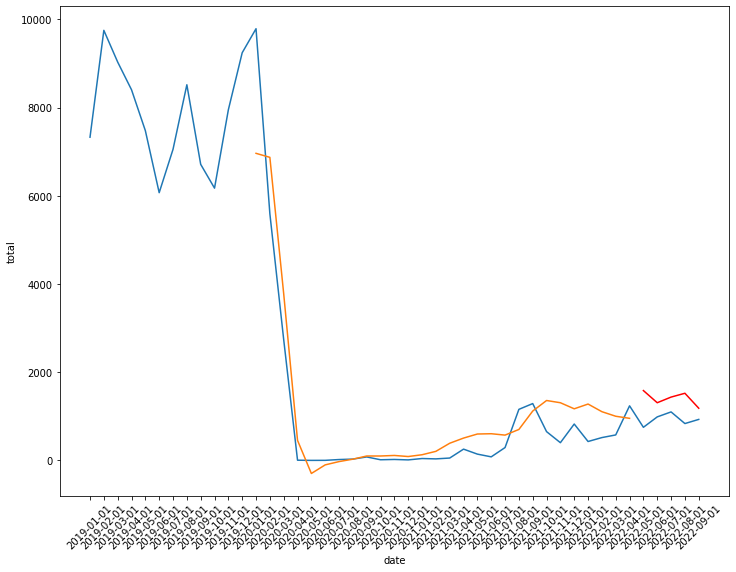

In [49]:
fig, ax = plt.subplots(figsize=(12,9))
sns.set_style("whitegrid")
sns.lineplot(data=palau, x="date", y="total")
sns.lineplot(data=y_train_df, x="date", y="total")
sns.lineplot(data=y_pred_df, x="date", y="total", color="red")
plt.xticks(rotation=45)
plt.show()